In [2]:
%load_ext autotime

In [52]:
%unload_ext autotime

In [3]:
import pandas as pd
import numpy as np    
import matplotlib.pyplot as plt

from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix

time: 4.28 s


## Data Post-processing:

### Import reviews file (i.e. pre-processed amazon-book-reviews created by `reviews_preprocessing.ipynb` ):

In [4]:
col_names = ['productID', 'title', 'price', 'userID', 'profileName', 
             'helpfulness', 'score', 'time', 'summary', 'text']
books_amazon = pd.read_csv('E://MRP//0102/Books.csv', nrows = 10, encoding = 'utf-8', names=col_names)

time: 532 ms


In [5]:
books_amazon

,productID,title,price,userID,profileName,helpfulness,score,time,summary,text
0,1882931173,Its Only Art If Its Well Hung!,unknown,AVCGYZL8FQQTD,"Jim of Oz ""jim-of-oz""",7/7,4.0,940636800,Nice collection of Julie Strain images,This is only for Julie Strain fans. It's a co...
1,826414346,Dr. Seuss,unknown,A30TK6U7DNS82R,Kevin Killian,10/10,5.0,1095724800,Really Enjoyed It,I don't care much for Dr. Seuss but after rea...
2,826414346,Dr. Seuss,unknown,A3UH4UZ4RSVO82,John Granger,10/11,5.0,1078790400,Essential for every personal and Public Library,"If people become the books they read and if ""..."
3,826414346,Dr. Seuss,unknown,A2MVUWT453QH61,"Roy E. Perry ""amateur philosopher""",7/7,4.0,1090713600,Phlip Nel gives silly Seuss a serious treatment,"Theodore Seuss Geisel (1904-1991), aka &quot;..."
4,826414346,Dr. Seuss,unknown,A22X4XUPKF66MR,"D. H. Richards ""ninthwavestore""",3/3,4.0,1107993600,Good academic overview,Philip Nel - Dr. Seuss
5,826414346,Dr. Seuss,unknown,A2F6NONFUDB6UK,Malvin,2/2,4.0,1127174400,One of America's greatest creative talents,"""Dr. Seuss"
6,826414346,Dr. Seuss,unknown,A14OJS0VWMOSWO,Midwest Book Review,3/4,5.0,1100131200,A memorably excellent survey of Dr. Seuss' ma...,Theodor Seuss Giesel was best known as 'Dr. S...
7,826414346,Dr. Seuss,unknown,A2RSSXTDZDUSH4,J. Squire,0/0,5.0,1231200000,Academia At It's Best,When I recieved this book as a gift for Chris...
8,826414346,Dr. Seuss,unknown,A25MD5I2GUIW6W,"J. P. HIGBED ""big fellow""",0/0,5.0,1209859200,And to think that I read it on the tram!,Trams (or any public transport) are not usual...
9,826414346,Dr. Seuss,unknown,A3VA4XFS5WNJO3,Donald Burnside,3/5,4.0,1076371200,Fascinating account of a genius at work,"As far as I am aware, this is the first book-..."


time: 15.6 ms


In [6]:
## Get all the book-names from Amaozn-data (later this list will be used to find crime-mystery books):
book_names = []
i = 0
with open ('E://MRP//0102/Books.csv') as books:
    for line in books:
        book_names.append(line.split(',')[1])

time: 1min 53s


## Clean the book-names:

In [7]:
unique_books = list(set(book_names))
unique_books = [book.strip().lower() for book in unique_books]
unique_books.sort()

time: 1.41 s


### Import goodreads file (i.e. data collected from `goodreads_data.ipynb`):

In [23]:
books_goodreads = pd.read_csv('C:\\Users\\patel.mehu\\Downloads\\Book-Recommender-System\\data\\books_df.csv', encoding = 'latin1')

books_goodreads['Books'] = [book.strip().lower() for book in books_goodreads['Books']]
books_goodreads['Total_Num_Ratings'] = [int(rating.replace(',','')) for rating in books_goodreads['Total_Num_Ratings']]
books_goodreads['Total_Num_Votes'] = [int(vote.replace(',','')) for vote in books_goodreads['Total_Num_Votes']]
books_goodreads['Avg_Rating'] = [float(rating.strip("['']")) for rating in books_goodreads['Avg_Rating']]

books_goodreads.head()

,Avg_Rating,Books,Total_Num_Ratings,Total_Num_Votes
0,4.12,"the girl with the dragon tattoo (millennium, #1)",2028253,2818
1,4.24,and then there were none,500620,2077
2,3.86,"angels & demons (robert langdon, #1)",2166178,1334
3,4.21,rebecca,342140,939
4,4.05,in cold blood,416759,765


time: 46.9 ms


### Found matches for only 1200 books out of 5000:

In [24]:
common_books = list(set(unique_books) & set(books_goodreads['Books']))
len(common_books)

1200

time: 173 ms


### Start building a recommendation system:

#### Efficient but incomplete method!

In [204]:
temp_book = ['Dr. Seuss', 'Its Only Art If Its Well Hung!']
# temp_books = set(common_books)

list_df = []
with open ('E://MRP//0102//Books.csv') as books:
    for i in range(5):
        line = books.readline()
        book = line.split(',')[1].strip()
        
        if book in temp_book:
            list_df.append(line)

 1882931173, Its Only Art If Its Well Hung!, unknown, AVCGYZL8FQQTD," Jim of Oz ""jim-of-oz""", 7/7, 4.0, 940636800, Nice collection of Julie Strain images," This is only for Julie Strain fans. It's a collection of her photos -- about 80 pages worth with a nice section of paintings by Olivia.If you're looking for heavy literary content, this isn't the place to find it -- there's only about 2 pages with text and everything else is photos.Bottom line"

 0826414346, Dr. Seuss, unknown, A30TK6U7DNS82R, Kevin Killian, 10/10, 5.0, 1095724800, Really Enjoyed It," I don't care much for Dr. Seuss but after reading Philip Nel's book I changed my mind--that's a good testimonial to the power of Rel's writing and thinking. Rel plays Dr. Seuss the ultimate compliment of treating him as a serious poet as well as one of the 20th century's most interesting visual artists, and after reading his book I decided that a trip to the Mandeville Collections of the library at University of California in San Die

#### Quick fix for incomplete-method:

In [25]:
# books_amazon_whole = pd.read_csv('E://MRP//0102/Books.csv', encoding = 'utf-8', names=col_names)
books_amazon_whole = pd.read_csv('E://MRP//0102/Books.csv', encoding = 'utf-8', 
                                 header=None, usecols=[0,1,3,6])
new_cols = ['BookID', 'BookTitle', 'UserID', 'Score']
books_amazon_whole.columns = new_cols
books_amazon_whole['BookTitle'] = [title.strip().lower() for title in books_amazon_whole['BookTitle']]
books_amazon_whole.head()

,BookID,BookTitle,UserID,Score
0,1882931173,its only art if its well hung!,AVCGYZL8FQQTD,4.0
1,0826414346,dr. seuss,A30TK6U7DNS82R,5.0
2,0826414346,dr. seuss,A3UH4UZ4RSVO82,5.0
3,0826414346,dr. seuss,A2MVUWT453QH61,4.0
4,0826414346,dr. seuss,A22X4XUPKF66MR,4.0


time: 1min 58s


In [26]:
books_amazon_whole = books_amazon_whole[books_amazon_whole['BookTitle'].isin(common_books)]
books_amazon_whole.head()

,BookID,BookTitle,UserID,Score
6099,B000OX8HJO,trust no one,A3KKFG3TA9IO8X,5.0
8349,1563331586,chains,A3EX36SNRYD5VL,3.0
11895,B000N1ZWS6,a study in scarlet and the sign of four,A3MV1KKHX51FYT,5.0
12730,0451210530,a rip in heaven,A1IMO4Q54CHVH5,4.0
12731,0451210530,a rip in heaven,A24VKWUKXWBWLV,3.0


time: 12.5 s


In [134]:
## Consider users who rated >1 books. Two reasons: 1) Expect to get better results; 2) Speeds-up calculation and easy to manage.
temp = pd.DataFrame(books_amazon_whole.groupby(by = 'UserID').size(), columns = ['count'])
temp = temp.loc[temp['count'] > 1]
temp.reset_index(drop = False, inplace = True)
temp = temp[temp['UserID'] != ' unknown']  ## Remove unknown user-ID which has given 949 ratings
temp = books_amazon_whole.loc[books_amazon_whole['UserID'].isin(temp['UserID'])]

In [136]:
books_amazon_whole.drop_duplicates(subset = ['BookTitle', 'UserID'], inplace = True)
user_item_df = pd.pivot_table(data = temp, index = 'UserID', columns = 'BookTitle', values = 'Score')
user_item_df.head()

BookTitle,13 for luck,24 hours,a cast of killers,a clockwork orange,a coffin for dimitrios,a cry in the night,a dark-adapted eye,a demon in my view,a discount for death,a dram of poison,...,widow's web,wildfire at midnight,windmills of the gods,windy city blues,wired,with murderous intent,woman on the run,worm,yellow-dog contract,you belong to me
UserID,,,,,,,,,,,,,,,,,,,,,
A0134066213WYQXLTVGYT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A100OZUQG1WYG9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A10101H7MYQDNW,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A101DG7P9E26PW,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A101OMG474Q26I,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [137]:
user_item_df.fillna(0, inplace=True)
new_book_names = user_item_df.columns

In [138]:
user_item_df.head()

BookTitle,13 for luck,24 hours,a cast of killers,a clockwork orange,a coffin for dimitrios,a cry in the night,a dark-adapted eye,a demon in my view,a discount for death,a dram of poison,...,widow's web,wildfire at midnight,windmills of the gods,windy city blues,wired,with murderous intent,woman on the run,worm,yellow-dog contract,you belong to me
UserID,,,,,,,,,,,,,,,,,,,,,
A0134066213WYQXLTVGYT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A100OZUQG1WYG9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10101H7MYQDNW,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A101DG7P9E26PW,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A101OMG474Q26I,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### In practise, the user-item matrices are very sparse. Following two plots help in understanding the sparsity of the data in this case.

### Ratings per user (i.e. number of books rated by a user) is very less. Most users rated only 1 book. So, user-user model may not result in a good recommendation system.

In [139]:
user_data = [np.count_nonzero(user_item_df.iloc[i,:]) for i in range(user_item_df.shape[0])]
book_data = [np.count_nonzero(user_item_df.iloc[:,i]) for i in range(user_item_df.shape[1])]

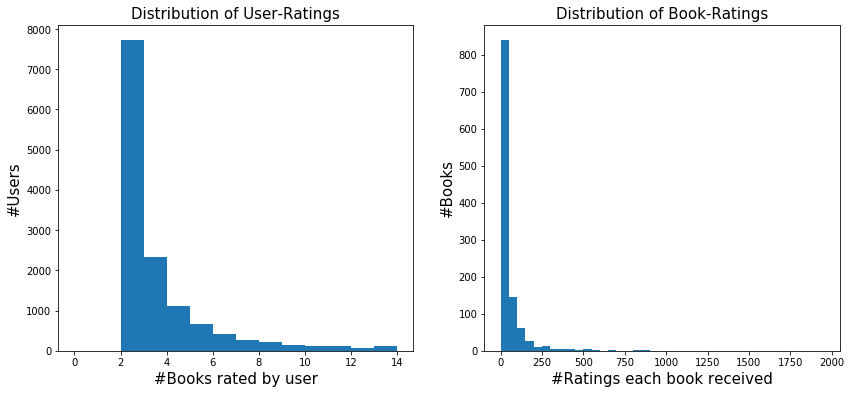

In [140]:
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (14,6))
ax1.hist(user_data, bins = range(0,15,1))
ax2.hist(book_data, bins = range(0, 2000,50))

ax1.set_title('Distribution of User-Ratings', fontsize = 15)
ax2.set_title('Distribution of Book-Ratings', fontsize = 15)

ax1.set_xlabel('#Books rated by user', fontsize = 15)
ax2.set_xlabel('#Ratings each book received', fontsize = 15)

ax1.set_ylabel('#Users', fontsize = 15)
ax2.set_ylabel('#Books', fontsize = 15)

plt.show()

### Item-item recommendation system:

In [155]:
user_item_mat = csr_matrix(user_item_df)
user_item_mat

<13676x1123 sparse matrix of type '<class 'numpy.float64'>'
	with 52905 stored elements in Compressed Sparse Row format>

In [78]:
# def get_dense_users(row):
#     if np.count_nonzero(user_item_mat[row,:].toarray()) > 1:
#         return row        
    
# subset_matrix_ind = [get_dense_users(row) for row in range(user_item_mat.shape[0])]

In [142]:
book_similarity_mat = cosine_similarity(user_item_mat.transpose(), dense_output = False)
book_similarity_mat = book_similarity_mat.toarray()
book_similarity_mat.shape

(1123, 1123)

### Make recommendations (item-item similarity based on user-ratings):

In [151]:
list(new_book_names).index('mystic river')

483

In [150]:
def most_similar_books(book_ind, book_names):
    
    most_sim_books = np.argsort(book_similarity_mat[book_ind,:])[::-1][0:20]
    recommended_books = [book_names[i] for i in most_sim_books]
    
    recommendation_df = pd.DataFrame({'BookIndex': most_sim_books, 'BookTitle': recommended_books, 
                                     'Similarity': similarity})
    
    print ('Target book: ', book_names[book_ind])
    
    return recommendation_df

most_similar_books(837, new_book_names)  ## Try: 837, 483

Target book:  the hound of the baskervilles


,BookIndex,BookTitle
0,837,the hound of the baskervilles
1,32,a study in scarlet
2,950,the return of sherlock holmes
3,1016,the valley of fear
4,877,the maltese falcon
5,971,the sign of four
6,715,the case-book of sherlock holmes
7,238,double indemnity
8,886,the memoirs of sherlock holmes
9,871,the lodger


In [152]:
most_similar_books(book_ind = 483, book_names = new_book_names)

Target book:  mystic river


,BookIndex,BookTitle
0,483,mystic river
1,621,shutter island
2,669,tell no one
3,503,no second chance
4,703,the bottoms
5,348,hostage
6,196,dead sleep
7,698,the blue nowhere
8,1,24 hours
9,142,chasing the dime


### Currently developing an evaluation metric to evaluate model's performance